In [36]:
import os
import sys
import datacube
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
from skimage import measure
import skimage.morphology
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
from datacube.utils import geometry
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
from otps import TimePoint
from otps import predict_tide
from dateutil.relativedelta import relativedelta
from collections import Counter
import warnings

sys.path.append('../10_Scripts')
import SpatialTools, DEAPlotting

# Create datacube instance
dc = datacube.Datacube(app='Tidal geomedian filmstrips')
dc_upgrade = datacube.Datacube(env='c3-samples')  #datacube.Datacube(config='/home/561/rt1527/.ard-interoperability_tmp.conf')


# Define custom functions
def water_indices(ds, water_index='NDWI', custom_varname=None, source='Collection2'): 
    
    """
    Takes an xarray dataset containing spectral bands, calculates one of a 
    series of water indices, and adds the resulting array as a new variable 
    in the original dataset.    

    Last modified: July 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------  
    ds : xarray Dataset
        A two-dimensional or multi-dimensional array with spectral bands named 
        'red', 'green', 'blue', 'nir', 'swir1' or 'swir2'. These bands are used
        as inputs to calculate the selected water index.
    water_index : str, optional
        A string giving the name of the water index to calculate. Valid options:
        'NDWI' (Normalised Difference Water Index, McFeeters 1996), 
        'MNDWI' (Modified Normalised Difference Water Index, Xu 1996), 
        'AWEI_ns (Automated Water Extraction Index - no shadows, Feyisa 2014)',
        'AWEI_sh' (Automated Water Extraction Index - shadows, Feyisa 2014), 
        'WI' (Water Index, Fisher 2016) & 'TCW' (Tasseled Cap Wetness, Crist 1985).
        Defaults to 'NDWI'.        
    custom_varname : str, optional
        By default, the function will return the original dataset with a new
        water index variable named after `water_index` (e.g. NDWI). To specify
        a custom name instead, you can supply e.g. `custom_varname='water_index'`. 

    Returns
    -------
    ds : xarray Dataset
        The original xarray Dataset inputted into the function, with a new band
        containing the water index DataArray.
    """           
   
    # Dictionary containing water index band recipes
    water_index_dict = {# Normalised Difference Water Index, McFeeters 1996
                        'NDWI': lambda ds: (ds.green - ds.nir) / (ds.green + ds.nir),
        
                        # Modified Normalised Difference Water Index, Xu 2006
                        'MNDWI': lambda ds: (ds.green - ds.swir1) / (ds.green + ds.swir1),
        
                        # Automated Water Extraction Index (no shadows), Feyisa 2014
                        'AWEI_ns': lambda ds: (4 * (ds.green - ds.swir1) -
                                               (2.5 * ds.nir * + 2.75 * ds.swir2)),
        
                        # Automated Water Extraction Index (shadows), Feyisa 2014
                        'AWEI_sh': lambda ds: (ds.blue + 2.5 * ds.green - 
                                               1.5 * (ds.nir + ds.swir1) - 2.5 * ds.swir2),
    
                        # Water Index, Fisher 2016
                        'WI': lambda ds: (1.7204 + 171 * ds.green + 3 * ds.red + 
                                          70 * ds.nir - 45 * ds.swir1 - 71 * ds.swir2),
        
                        # Tasseled Cap Wetness, Crist 1985
                        'TCW': lambda ds: (0.0315 * ds.blue + 0.2021 * ds.green + 
                                           0.3102 * ds.red + 0.1594 * ds.nir - 
                                           0.6806 * ds.swir1 - 0.6109 * ds.swir2)} 
    
    # Select a water index function based on 'water_index'    
    water_index_func = water_index_dict[water_index]
    
    # Rename bands to a consistent format if either 'Collection3'
    # or 'Sentinel2' is specified by `source`
    if source == 'Collection3':
        
        # Dictionary mapping full data names to simpler 'red' alias names
        bandnames_dict = {'nbart_red': 'red', 'nbart_green': 'green',
                          'nbart_blue': 'blue', 'nbart_nir': 'nir',
                          'nbart_swir_1': 'swir1', 'nbart_swir_2': 'swir2',
                          'nbar_red': 'red', 'nbar_green': 'green',
                          'nbar_blue': 'blue', 'nbar_nir': 'nir', 
                          'nbar_swir_1': 'swir1', 'nbar_swir_2': 'swir2'}

        # Rename bands in dataset to use simple names (e.g. 'red')
        bands_to_rename = {a: b for a, b in bandnames_dict.items() if a in ds.variables}
        
    elif source == 'Sentinel2':
        
        # Dictionary mapping full data names to simpler 'red' alias names
        bandnames_dict = {'nbart_red': 'red', 'nbart_green': 'green',
                          'nbart_blue': 'blue', 'nbart_nir': 'nir',
                          'nbart_swir_2': 'swir1', 'nbart_swir_3': 'swir2',
                          'nbar_red': 'red', 'nbar_green': 'green',
                          'nbar_blue': 'blue', 'nbar_nir': 'nir',
                          'nbar_swir_2': 'swir1', 'nbar_swir_3': 'swir2'}

        # Rename bands in dataset to use simple names (e.g. 'red')
        bands_to_rename = {a: b for a, b in bandnames_dict.items() if a in ds.variables}

    elif source == 'Collection2':
        
        # For the DEA Collection 2, pass an empty dict as no bands need renaming
        bands_to_rename = {}

    
    # Apply water index function to data and add to input dataset. If a custom name
    # is supplied for the output water index variable, use it.
    if custom_varname:        
        
        # Apply function after normalising to a 0.0-1.0 range by dividing by 10,000
        ds[custom_varname] = water_index_func(ds.rename(bands_to_rename) / 10000.0)
        
    else:
        
        # Apply function after normalising to a 0.0-1.0 range by dividing by 10,000
        ds[water_index] = water_index_func(ds.rename(bands_to_rename) / 10000.0)
    
    # Return input dataset with added water index variable
    return ds


def date_range(start_date, end_date, freq = '1YS'):
    
    '''
    Generates a dictionary of from-to date ranges based on a start and end date, and
    a temporal frequency (e.g. annually or six-monthly etc).
    
    Frequencies are based on Panda's date offset objects - see the following list:
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects.
    Options include annual ('1YS'), every 6 months ('6MS') etc.
    
    Outputs a dictionary with each time range named by its starting date.
    '''    

    # Convert to list of from-to dates. 
    from_dates = pd.date_range(start_date, end_date, freq=freq)[:-1].astype(str).values
    to_dates = pd.date_range(start_date, end_date, freq=freq)[1:].astype(str).values
    
    # Combine into a dictionary. Starting dates for each range are used to name output files.
    date_ranges = {a: (a, b) for (a, b) in np.dstack([from_dates, to_dates])[0]}
    
    return date_ranges


def mostcommon_utm(dc, product, query):    
    
    '''
    Takes a given query and returns the most common UTM zone for 
    observations returned for that spatial extent.
    
    '''
    
    # List of matching products
    matching_datasets = dc.find_datasets(product=product, **query)
    
    # Extract all CRSs
    crs_list = [str(i.crs) for i in matching_datasets]    
   
    # Identify most common CRS
    crs_counts = Counter(crs_list)    
    crs_mostcommon = crs_counts.most_common(1)[0][0]

    # Warn user if multiple CRSs are encountered
    if len(crs_counts.keys()) > 1:

        warnings.warn(f'Multiple UTM zones {list(crs_counts.keys())} were returned for this query.' 
                      f'Defaulting to the most common zone: {crs_mostcommon}', UserWarning)
    
    return crs_mostcommon


def tidal_tag(ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False):
    
    if not tidepost_lat or not tidepost_lon:

        tidepost_lon, tidepost_lat = ds.extent.centroid.to_crs(crs=CRS('EPSG:4326')).coords[0]
        print(f'Setting tide post from dataset centroid: {tidepost_lon}, {tidepost_lat}')

    else:
        print(f'Using user-supplied tide post: {tidepost_lon}, {tidepost_lat}')

    # Use the tidal mode to compute tide heights for each observation:
    obs_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()
    obs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in obs_datetimes]
    obs_predictedtides = predict_tide(obs_timepoints)

    # If tides cannot be successfully modeled (e.g. if the centre of the xarray dataset 
    # is located is over land), raise an exception 
    if len(obs_predictedtides) == 0:

        raise ValueError(f'Tides could not be modelled for dataset centroid located at '
                         f'{tidepost_lon}, {tidepost_lat}. This can happen if this coordinate '
                         f'occurs over land. Please manually specify a tide modelling post '
                         f'located over water using the `tidepost_lat` and `tidepost_lon` parameters.')

    else:

        # Extract tide heights
        obs_tideheights = [predictedtide.tide_m for predictedtide in obs_predictedtides]

        # Assign tide heights to the dataset as a new variable
        ds['tide_heights'] = xr.DataArray(obs_tideheights, [('time', ds.time)])

        # If swap_dims = True, make tide height the primary dimension instead of time
        if swap_dims:

            # Swap dimensions and sort by tide height
            ds = ds.swap_dims({'time': 'tide_heights'})
            ds = ds.sortby('tide_heights')     

        return ds

from scipy import stats
import pandas as pd

def change_regress(row, x_vals, x_labels, std_dev=3):
    
    # Extract x (time) and y (distance) values
    x = x_vals
    y = row.values[1:].astype(np.float)
    
    # Drop NAN rows
    xy_df = np.vstack([x, y]).T
    is_valid = ~np.isnan(xy_df).any(axis=1)
    xy_df = xy_df[is_valid]
    valid_labels = x_labels[is_valid]
    
    # Remove outliers
    outlier_bool = (np.abs(stats.zscore(xy_df)) < float(std_dev)).all(axis=1)
    xy_df = xy_df[outlier_bool]
        
    # Compute linear regression
    lin_reg = stats.linregress(x=xy_df[:,0], 
                               y=xy_df[:,1])
    
    # Return slope, p-values and list of outlier years excluded from regression   
    return pd.Series({'slope': np.round(lin_reg.slope, 2), 
                      'pvalue': np.round(lin_reg.pvalue, 3),
                      'outliers': str(valid_labels[~outlier_bool]).replace('[', '').replace(']', '')})


def load_cloudmaskedlandsat(dc, query, output_crs, platform='ls8', bands=['red', 'green', 'blue']):
    
    '''
    This function returns cloud-masked Landsat `*_nbar_scene` data by loading 
    both Landsat and Landsat pixel quality data and masking out any pixels 
    affected by cloud, cloud shadow, saturated pixels or any pixels missing data 
    in any band. For convenience, the resulting data is returned with sensible
    band names (e.g. 'red', 'green', 'blue') instead of the unnamed bands in the
    original data.
    
    Last modified: March 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------  
    dc : datacube Datacube object
        A specific Datacube to import from, i.e. `dc = datacube.Datacube(app='Clear Landsat')`. This allows you to 
        also use development datacubes if they have been imported into the environment.    
    query : dict
        A dict containing the query bounds. Can include lat/lon, time etc. If no `time` query is given, the 
        function defaults to all timesteps available to all sensors (e.g. 1987-2018)
    platform : list, optional
        An optional Landsat platform name to load data from. Options are 'ls5', 'ls7', 'ls8'.
    bands : list, optional
        An optional list of strings containing the bands to be read in; options include 'red', 'green', 'blue', 
        'nir', 'swir1', 'swir2'; defaults to `['red', 'green', 'blue']`.
        
    Returns
    -------
    landsat_ds : xarray Dataset
        An xarray dataset containing pixel-quality masked Landsat observations        
        
    '''
    
    # Define dictionary for converting band names between numbered 
    # (e.g. '2', '3', '4') and named bands (e.g. 'red', 'green', 'blue')
    if (platform == 'ls5') or (platform == 'ls7'):
    
        band_nametonum = {'blue': '1', 'green': '2', 'red': '3', 
                          'nir': '4', 'swir1': '5', 'swir2': '7'}
        
    else:
        
        band_nametonum = {'coastal': '1', 'blue': '2', 'green': '3', 
                  'red': '4', 'nir': '5', 'swir1': '6', 'swir2': '7'}

    
    # Test if data is available for query
    n_obs = len(dc.find_datasets(product=f'{platform}_nbar_scene', **query))
    if n_obs > 0:

        print(f'Loading data for {n_obs} {platform} observations')
        landsat_ds = dc.load(product=f'{platform}_nbart_scene', 
                             measurements=[band_nametonum[i] for i in bands],
                             group_by='solar_day', 
                             dask_chunks={'time': 1},  
                             output_crs=output_crs,
                             resolution=(-25, 25),
                             resampling='cubic',
                             skip_broken_datasets=True,
                             **query)

        print(f'Loading pixel quality data for {n_obs} {platform} observations')
        landsat_pq = dc.load(product=f'{platform}_pq_scene', 
                             group_by='solar_day', 
                             fuse_func=ga_pq_fuser,
                             output_crs=output_crs,
                             dask_chunks={'time': 1},
                             resolution=(-25, 25),
                             skip_broken_datasets=True,
                             **query)

        print('Masking out poor quality pixels (e.g. cloud)')
        good_quality = masking.make_mask(landsat_pq.pqa,                        
                                     cloud_acca='no_cloud',
                                     cloud_shadow_acca='no_cloud_shadow',
                                     cloud_shadow_fmask='no_cloud_shadow',
                                     cloud_fmask='no_cloud',
                                     blue_saturated=False,
                                     green_saturated=False,
                                     red_saturated=False,
                                     nir_saturated=False,
                                     swir1_saturated=False,
                                     swir2_saturated=False,
                                     contiguous=True)

        # Apply pixel quality mask
        landsat_ds = landsat_ds.where(good_quality)

        # Rename bands to useful names and return data
        band_numtoname = {b: a for a, b in band_nametonum.items() if a in bands}
        landsat_ds = landsat_ds.rename(band_numtoname)

        return landsat_ds
    
    else:
        raise Exception(f'No data was returned for the query {query}. '
                        'Please change lat, lon and time extents to an area with data.')        
    

def largest_region(bool_array, **kwargs):
    
    '''
    Takes a boolean array and identifies the largest contiguous region of 
    connected True values. This is returned as a new array with cells in 
    the largest region marked as True, and all other cells marked as False.
    
    Last modified: August 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------  
    bool_array : boolean array
        A boolean array (numpy or xarray DataArray) with True values for
        the areas that will be inspected to find the largest group of 
        connected cells
    **kwargs : 
        Optional keyword arguments to pass to `measure.label`
        
    Returns
    -------
    largest_region : boolean array
        A boolean array with cells in the largest region marked as True, 
        and all other cells marked as False.       
        
    '''

    # First, break boolean array into unique, descrete regions/blobs
    blobs_labels = measure.label(bool_array, background=0, **kwargs)
    
    # Count the size of each blob, excluding the background class (0)
    ids, counts = np.unique(blobs_labels[blobs_labels > 0], 
                            return_counts=True) 
    
    # Identify the region ID of the largest blob
    largest_region_id = ids[np.argmax(counts)]
    
    # Produce a boolean array where 1 == the largest region
    largest_region = blobs_labels == largest_region_id
    
    return largest_region
        

import warnings
warnings.simplefilter('ignore', FutureWarning)


In [3]:
# # todo
# 1) Add SOI stats to contour file
# 2) Fix outlier data for SOI/el nino years
# 3) Add pos/neg SOI as well as La Nina/El Nino SOI
# 4) Clip by smartline? Excluding estauries?

## Set spatial query

In [44]:
# # Option 1: For a set of discontinuous or unevenly sized time steps (e.g. climatic periods, before-after development).
# # Each set of dates will be exported as an individual shoreline
# study_area = 'tweed_custom'  # Name used as prefix for output files
# lat_extents = (-28.15, -28.19)   
# lon_extents = (153.51, 153.56)
# time_periods = {'elnino_1': ('1991-01-01', '1995-01-01'),
#                 'lanina_1': ('1998-02-01', '2001-01-01')}

# # Option 1: For a set of discontinuous or unevenly sized time steps (e.g. climatic periods, before-after development).
# study_area = 'adelaide_custom'  # Name used as prefix for output files
# lat_extents = (-34.88, -34.96)   
# lon_extents = (138.48, 138.52)
# time_periods = {'elnino_1': ('1990-01-01', '1991-06-01'),
#                 'lanina_1': ('1993-01-01', '1994-01-01'),
#                 'elnino_2': ('1994-01-01', '1995-01-01')}

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'adelaide'  # Name used as prefix for output files
# lat_extents = (-34.755, -35.3391)   
# lon_extents = (138.4194, 138.5249)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'cabarita'  # Name used as prefix for output files
# lat_extents = (-27.65, -29.43)   
# lon_extents = (153.3197, 153.65)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'avoca'  # Name used as prefix for output files
# lat_extents = (-32.8168, -34.0528)   
# lon_extents = (151.0785, 151.9347)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'pilbara'  # Name used as prefix for output files
# lat_extents = ( -21.2890, -22.100)   
# lon_extents = (114.4546, 115.5185)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'pointstuart'  # Name used as prefix for output files
# lat_extents = (-12.00, -12.33)   
# lon_extents = (131.20, 132.71)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'cabarita'  # Name used as prefix for output files
# lat_extents = (-27.90, -29.43)   
# lon_extents = (153.3197, 153.65)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'cabarita_small'  # Name used as prefix for output files
# lat_extents = (-28.0530, -28.4530)      
# lon_extents = (153.4063, 153.6063)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'fremantle'  # Name used as prefix for output files
# lat_extents = (-31.8, -32.15)   
# lon_extents = (115.7211, 115.767)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'murraymouth'  # Name used as prefix for output files
# lat_extents = (-35.535, -35.575)   
# lon_extents = (138.852, 138.912)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'lancelin'  # Name used as prefix for output files
# lat_extents = (-30.99, -31.04)   
# lon_extents = (115.319168, 115.34)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '2YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'fremantle2'  # Name used as prefix for output files
# lat_extents = (-32.29, -32.55)    
# lon_extents = (115.68, 115.755 )
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'fremantle3'  # Name used as prefix for output files
# lat_extents = (-31.73, -32.28)    
# lon_extents = (115.72, 115.78 )
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'rottnest'  # Name used as prefix for output files
# lat_extents = (-31.98, -32.035)    
# lon_extents = (115.44, 115.57)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'montgomery'  # Name used as prefix for output files
# lat_extents = (-15.892, -15.992)    
# lon_extents = (124.14, 124.25)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '3YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'whitsunday'  # Name used as prefix for output files
# lat_extents = (-20.00, -20.40)       
# lon_extents = (148.85, 149.15)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '3YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'coorong'  # Name used as prefix for output files
# lat_extents = (-35.925647, -36.222017)
# lon_extents = (139.420407, 139.706323)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'byronbay'  # Name used as prefix for output files
# lat_extents = (-28.619206, -28.659206)   
# lon_extents = (153.582995, 153.642995)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
study_area = 'qldnsw'  # Name used as prefix for output files
lat_extents = (-27.37, -28.53)   
lon_extents = (153.4097, 153.60)
time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')



# Optional parameters
min_tide_perc = 0.5  # Minumum percentile of the observed tidal range to include (e.g. 0.5 = median tide height)
max_tide_perc = 1.0  # Maximum percentile of the observed tidal range to include (e.g. 1.0 = maximum tide height)
water_index = 'MNDWI'  # Water index used to extract waterlines. Options are 'mndwi', 'ndwi', 'awei_s', 'awei_ns'
index_threshold = 0  # Threshold used to extract waterlines. Generally, this will be near to 0
min_vertices = 2  # Minimum size of waterlines in vertexes to extract. Larger values remove small, isolated waterlines
sensors = ['ls5', 'ls7', 'ls8']  # Landsat satellites to load (e.g. Landsat 5, 7, 8)

# Preview area
DEAPlotting.display_map(x=lon_extents, y=lat_extents, crs='EPSG:4326')

## Load satellite data

This will first attempt to extract data from the collection upgrade DEA Landsat Collection 3 data to avoid jagged resampling artefacts in the output contours. If this is not possible, it will revert to importing DEA Landsat Collection 2 data which will produce jagged contours due to nearest neighbour resampling that was originally used when the data was ingested into the datacube.

In [45]:
# If output data and figure directories doesn't exist, create them
if not os.path.isdir('output_data/{}/'.format(study_area)):
    os.makedirs('output_data/{}/'.format(study_area))

# Create a query based on lat and lon extents and all of time. This is filtered by tide
# and time periods (using `dask`) before any data is actually loaded
query = {'y': lat_extents,
         'x': lon_extents,
         'crs': 'EPSG:4326',
         'time': ('1986-01-01', '2020-01-01')}

# Output dicts to hold entire time-series for each sensor
sensor_dict = {}

# First try using collection upgrade DEA Landsat Collection 3 data to avoid jagged resampling artefacts
try:

    # Obtain output CRS by taking the most common value of matching Landsat 5 observations
    output_crs = mostcommon_utm(dc=dc_upgrade, product='ga_ls5t_ard_3', query=query)

    # For each sensor, dask load data and compute tide heights for each sensor
    for sensor in sensors:    

        # Return observations matching query without actually loading them using dask
        prod_dict = {'ls5': 'ls5t', 'ls7': 'ls7e', 'ls8': 'ls8c'}
        sensor_ds = dc_upgrade.load(product=f'ga_{prod_dict[sensor]}_ard_3', 
                                    measurements=['nbart_red', 'nbart_green', 'nbart_blue', 
                                                  'nbart_nir', 'nbart_swir_1', 'nbart_swir_2', 'fmask'],
                                    group_by='solar_day', 
                                    output_crs=output_crs,
                                    resolution=(-30, 30),
                                    gqa_iterative_mean_xy=(0, 1),  # Tolerate no more than a one pixel shift
                                    align=(15, 15),  # Fix for 15m NW offset in collection upgrade
                                    resampling={'*': 'cubic', 'fmask': 'nearest'},
                                    dask_chunks={'time': 1},  # Lazily load data
                                    **query)  

        # Mask data by pixel quality/fmask to remove cloud, shadow, nodata etc
        bad_quality = (sensor_ds.fmask == 0) | (sensor_ds.fmask == 2) | (sensor_ds.fmask == 3)
        sensor_ds = sensor_ds.where(~bad_quality)    

        # Append results for each sensor to a dictionary with sensor name as the key
        sensor_ds = sensor_ds.rename({'nbart_red': 'red', 'nbart_blue': 'blue', 'nbart_green': 'green', 
                                      'nbart_nir': 'nir', 'nbart_swir_1': 'swir1', 'nbart_swir_2': 'swir2'})
        
        # Append cloud filtered sensor data to dictionary
        sensor_dict[sensor] = sensor_ds
        
# If DEA Collection 3 data is not available, revert to using DEA Landsat Collection 2
except:
        
    print('Collection upgrade data (DEA Landsat Collection 3) is unavailable for this location. '
          'Reverting to DEA Landsat Collection 2 (contours may be affected by resampling artefacts)')  
    
    # Obtain output CRS by taking the most common value of matching Landsat 5 observations
    output_crs = mostcommon_utm(dc=dc, product='ls5_nbart_scene', query=query)
  
    # For each sensor, dask load data and compute tide heights for each sensor
    for sensor in sensors:       

        # Load in scene data
        sensor_ds = load_cloudmaskedlandsat(dc, query, platform=sensor, 
                                            bands=['red', 'green', 'blue', 'nir', 'swir1', 'swir2'], 
                                            output_crs=output_crs)

        # Append cloud filtered sensor data to dictionary
        sensor_dict[sensor] = sensor_ds   
    
# Combine into a single xarray dataset
all_ds = xr.concat(sensor_dict.values(), dim='time')
all_ds = all_ds.sortby('time')

# Tag with tide heights and compute percentile tide heights
# all_ds = tidal_tag(all_ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False)  
all_ds = tidal_tag(all_ds, tidepost_lat= -28.0865, tidepost_lon=153.5724, swap_dims=False) 
min_tide_thresh = all_ds.tide_heights.quantile(min_tide_perc).item()
max_tide_thresh = all_ds.tide_heights.quantile(max_tide_perc).item()

# Clip to tide range between min and max percentiles
all_ds = all_ds.sel(time=(all_ds.tide_heights > min_tide_thresh) & (all_ds.tide_heights <= max_tide_thresh))


Using user-supplied tide post: 153.5724, -28.0865


## Generate median water index composites for each time period in `time_periods`

In [46]:
# Compute water indices
all_ds = water_indices(ds=all_ds, 
                       water_index=water_index, 
                       custom_varname='water_index', 
                       source='Collection2')

# Create median composites for each timestep
composite_list = []

# Actually load data for the first time for each time period, and generate median water index composite
for name, time_period in time_periods.items():
    
    print(f'Generating median composites for timestep {name} (from {time_period[0]} to {time_period[1]})')
    
    # Load time period subset
    subset_ds = all_ds.sel(time=slice(time_period[0], time_period[1])).compute()
    
    # Compute median of water index and tide heights
    median_comp = subset_ds[['tide_heights', 'water_index']].median(dim='time', keep_attrs=True)
    
    # Create ocean mask and buffer by one pixel
    ocean_mask = largest_region(median_comp.water_index > index_threshold)
    ocean_mask = skimage.morphology.binary_dilation(ocean_mask)

    # Mask array to only buffered ocean area to keep shoreline
    median_comp['water_index_clip'] = median_comp.water_index.where(ocean_mask)
    median_comp.attrs['crs'] = subset_ds.crs  # Copy CRS because '.where' squashes it
    
    # Compute number of obs
    n_count = subset_ds[['water_index']].count(dim='time', keep_attrs=True).astype('int16')
    n_count.attrs['crs'] = subset_ds.crs  # Copy CRS because 'astype' squashes it
    
    # Compute number of observations and min//max/standard deviation of tide heights
    median_comp['tide_m_min'] = subset_ds.tide_heights.min(dim='time', keep_attrs=True)
    median_comp['tide_m_max'] = subset_ds.tide_heights.max(dim='time', keep_attrs=True)
    median_comp['tide_m_std'] = subset_ds.tide_heights.std(dim='time', keep_attrs=True)
    median_comp['obs_n'] = len(subset_ds.time)
    
    # Export water index to file
    filename = f'output_data/{study_area}/{study_area}_{name}_{water_index}.tif'
    write_geotiff(filename=filename, dataset=median_comp[['water_index_clip']]) 
    
    # Export obs count to file
    filename = f'output_data/{study_area}/{study_area}_{name}_{water_index}_count.tif'
    write_geotiff(filename=filename, dataset=n_count[['water_index']])      
    
    composite_list.append(median_comp)
    
# Combine into one dataset with dimension names
composite_ds = xr.concat(composite_list, dim='timeperiod')
composite_ds = composite_ds.assign_coords(timeperiod = list(time_periods.keys()))
print(composite_ds)


Generating median composites for timestep 1987-01-01 (from 1987-01-01 to 1988-01-01)
Generating median composites for timestep 1988-01-01 (from 1988-01-01 to 1989-01-01)
Generating median composites for timestep 1989-01-01 (from 1989-01-01 to 1990-01-01)
Generating median composites for timestep 1990-01-01 (from 1990-01-01 to 1991-01-01)
Generating median composites for timestep 1991-01-01 (from 1991-01-01 to 1992-01-01)
Generating median composites for timestep 1992-01-01 (from 1992-01-01 to 1993-01-01)
Generating median composites for timestep 1993-01-01 (from 1993-01-01 to 1994-01-01)
Generating median composites for timestep 1994-01-01 (from 1994-01-01 to 1995-01-01)
Generating median composites for timestep 1995-01-01 (from 1995-01-01 to 1996-01-01)
Generating median composites for timestep 1996-01-01 (from 1996-01-01 to 1997-01-01)
Generating median composites for timestep 1997-01-01 (from 1997-01-01 to 1998-01-01)
Generating median composites for timestep 1998-01-01 (from 1998-0

In [7]:
# (all_ds.sel(time='1998').isel(y=slice(1700, 2500), x=slice(0, 700)).fmask).plot(col='time', col_wrap=3, size=10)

# ds.flags_definition


# # Actually load data for the first time for each time period, and generate median water index composite
# name, time_period in time_periods.items()

name = '1998-01-01'
time_period = ('1998-01-01', '1999-01-01')

print(f'Generating median composites for timestep {name} (from {time_period[0]} to {time_period[1]})')
    
# Load time period subset
subset_ds = all_ds.sel(time=slice(time_period[0], time_period[1])).compute()
    
    # Compute median of water index and tide heights
#     median_comp = subset_ds[['tide_heights', 'water_index']].median(dim='time', keep_attrs=True)

# time_periods['1998-01-01']

Generating median composites for timestep 1998-01-01 (from 1998-01-01 to 1999-01-01)


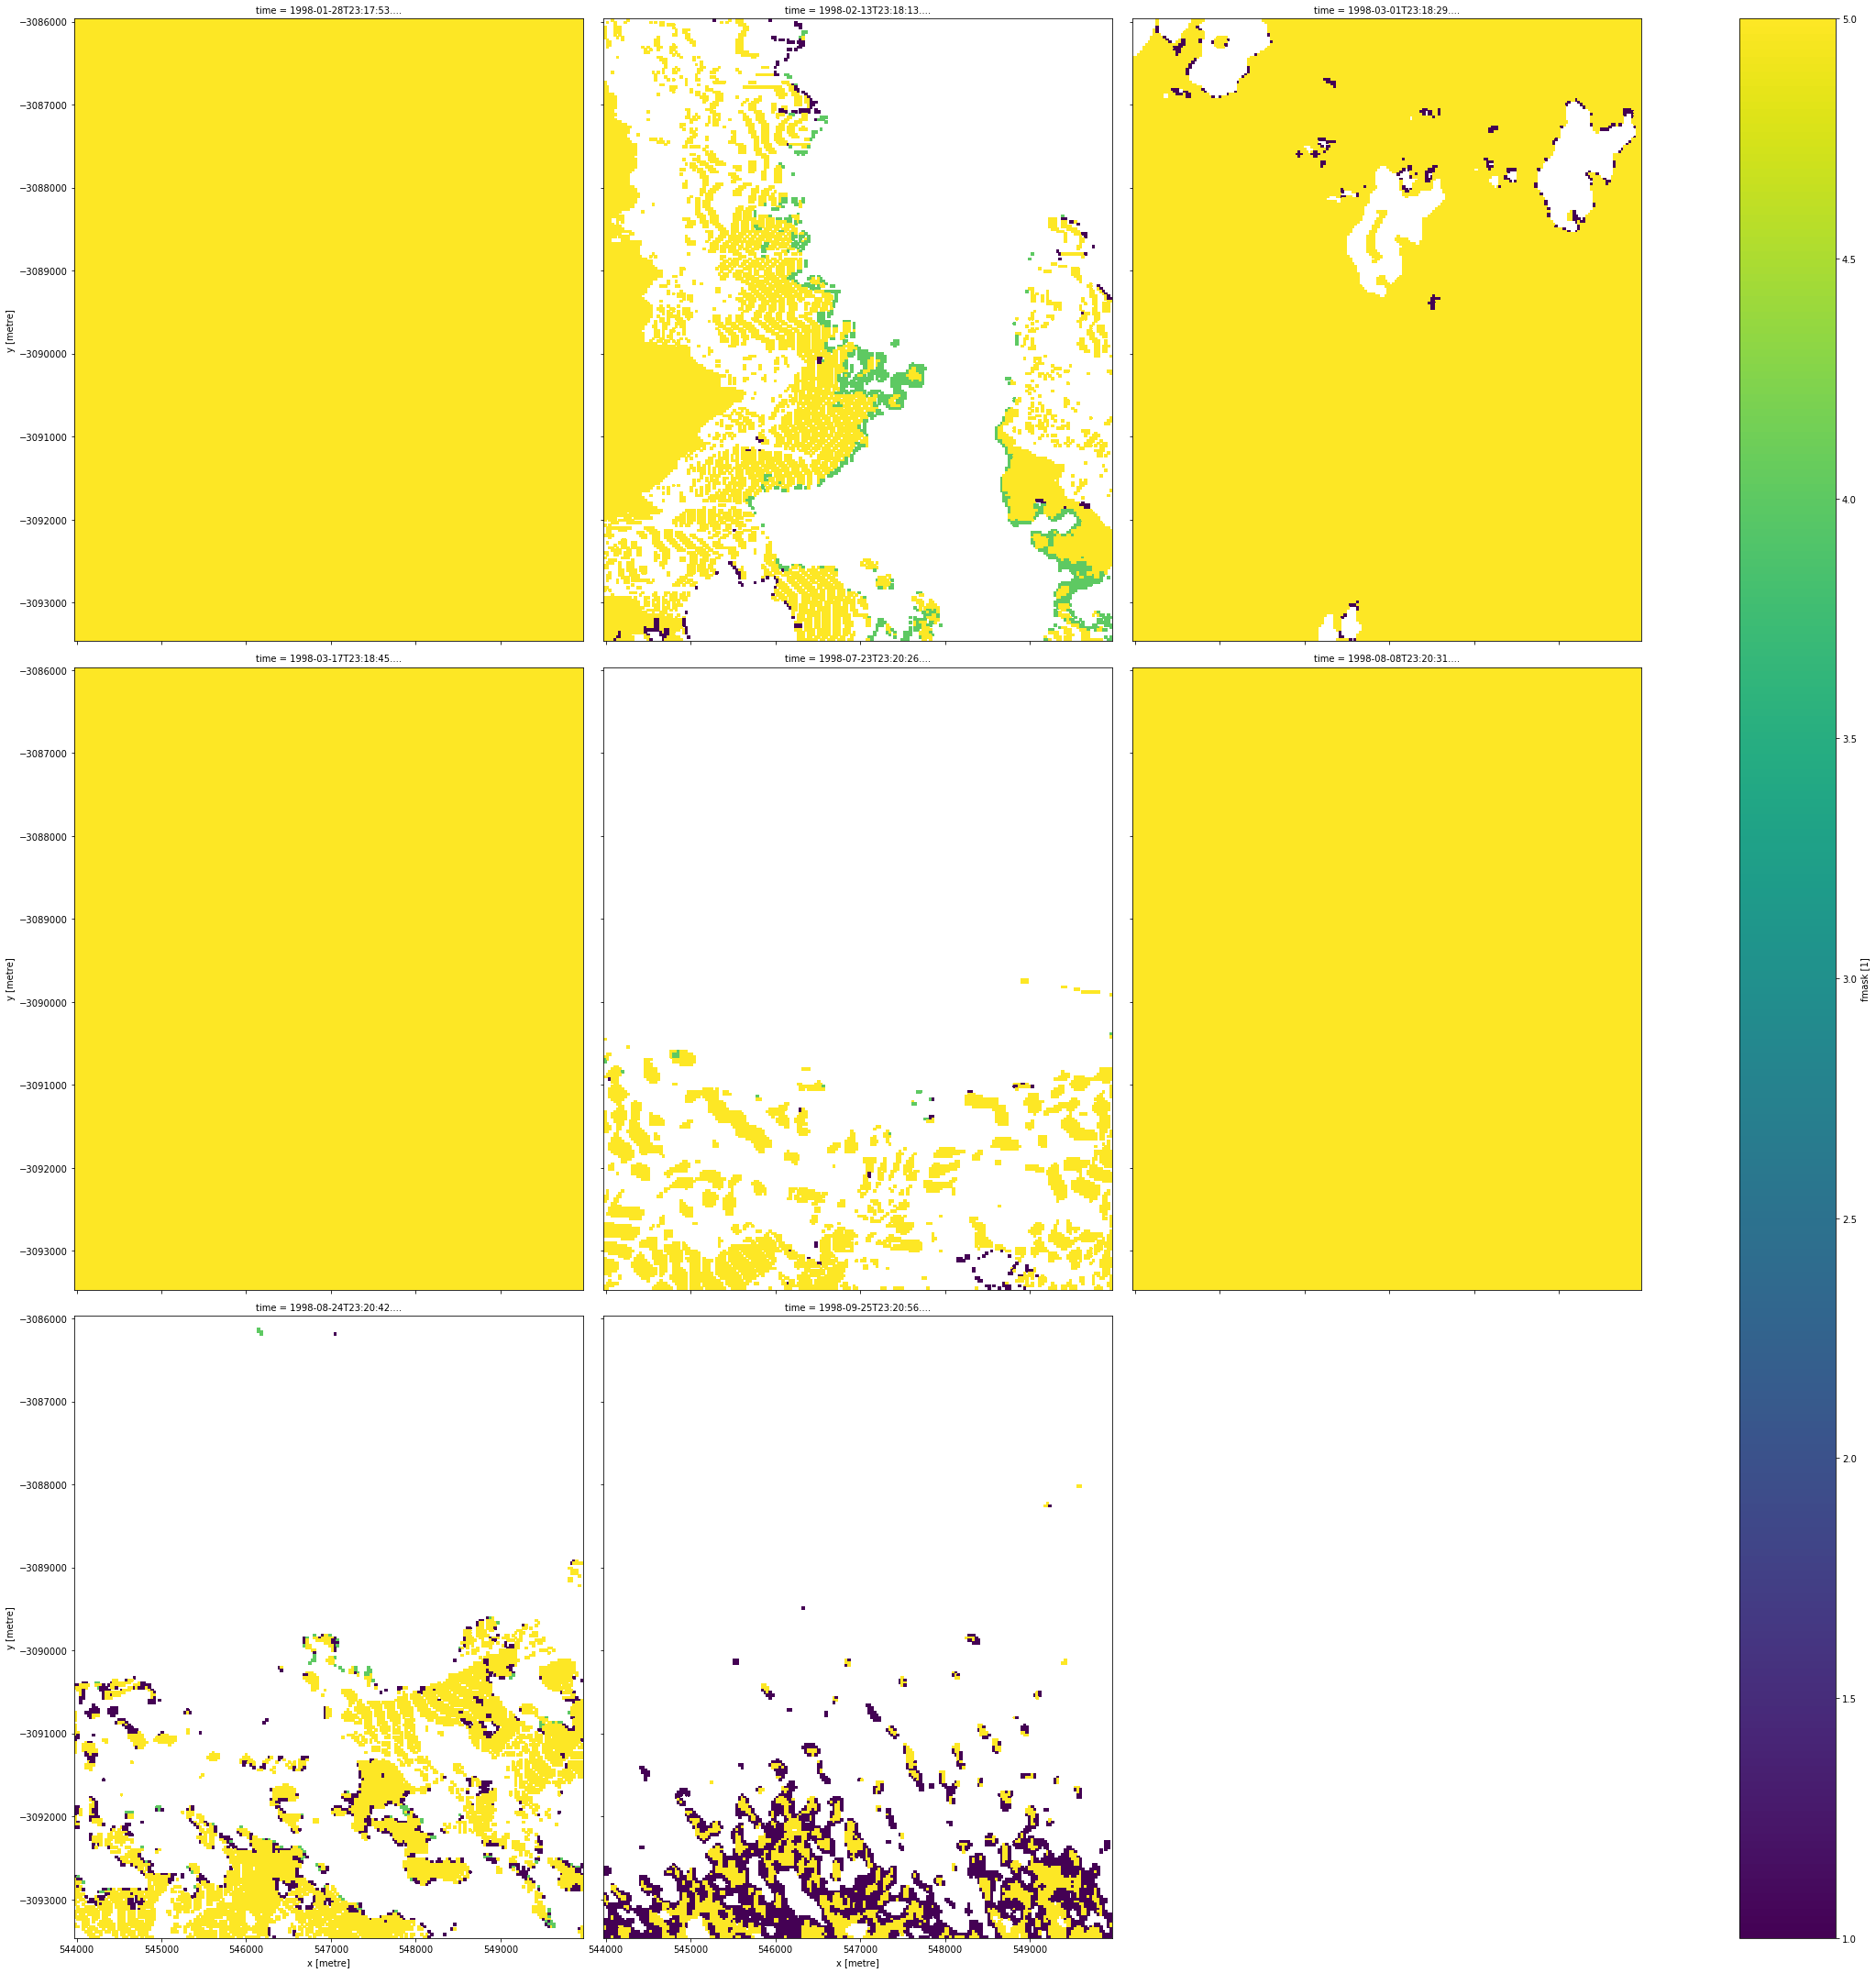

In [9]:
subset_ds.isel(y=slice(1950, 2200), x=slice(130, 330)).fmask.plot(col='time', col_wrap=3, size=10)

In [60]:
n_count = subset_ds[['water_index']].count(dim='time', keep_attrs=True).astype('int16')

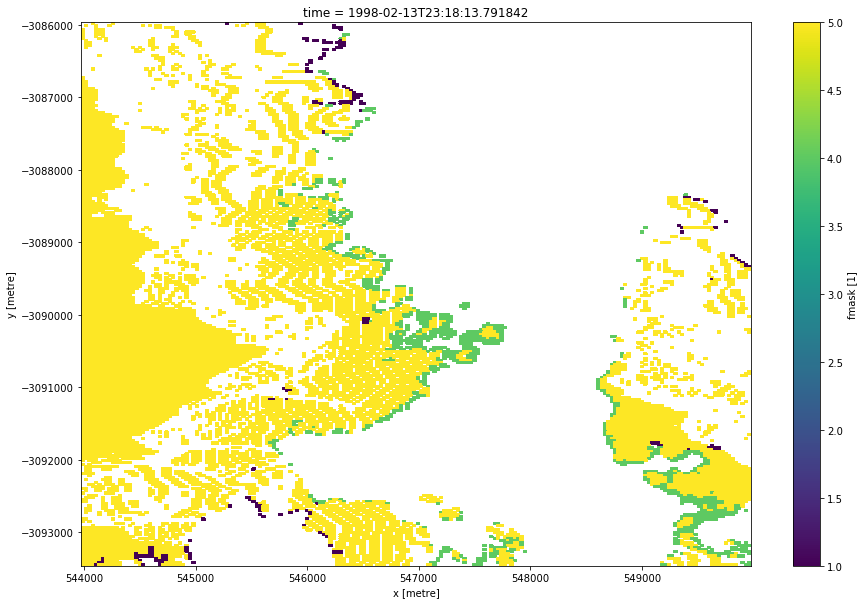

In [10]:
# n_count.water_index.isel(y=slice(1950, 2200), x=slice(130, 330)).plot(size=10)

subset_ds.fmask.isel(time=1, y=slice(1950, 2200), x=slice(130, 330)).plot(size=10)

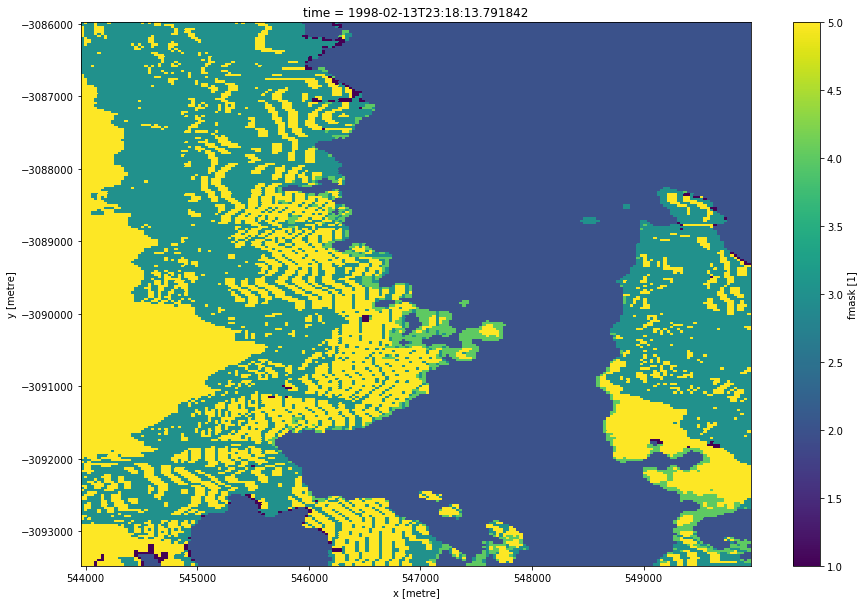

In [33]:
query = {'y': (-27.37, -28.53),
         'x': (153.4097, 153.6),
         'crs': 'EPSG:4326',
         'time': ('1998-02-12', '1998-02-14')}

test_ds = dc_upgrade.load(product=f'ga_ls5t_ard_3', 
                measurements=['nbart_red', 'nbart_green', 'nbart_blue', 'fmask'],
                group_by='solar_day', 
                output_crs='epsg:32656',
                resampling='nearest',
                resolution=(-30, 30),
                **query)  

test_ds.fmask.isel(time=0, y=slice(1950, 2200), x=slice(130, 330)).plot(size=10)

In [31]:
test_ds.fmask.flags_definition

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

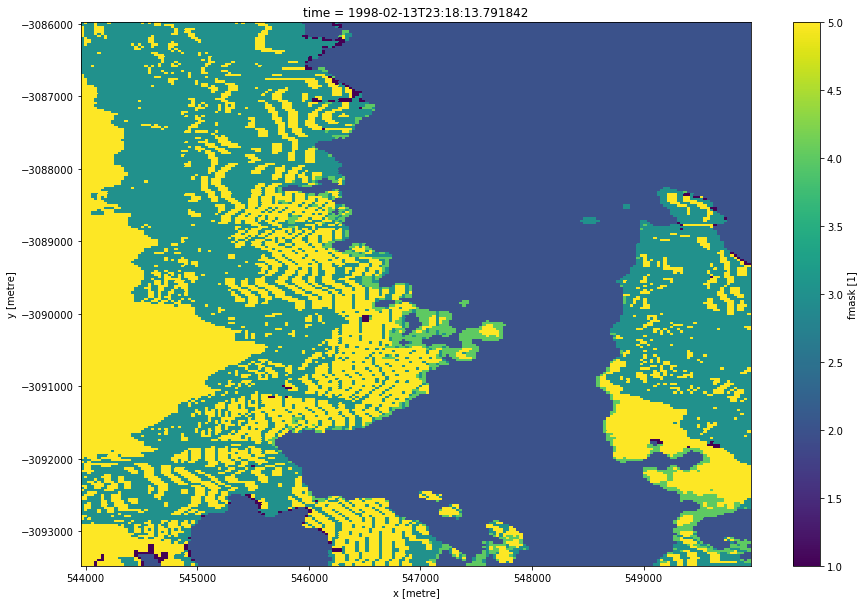

In [32]:
test_ds.fmask.isel(time=0, y=slice(1950, 2200), x=slice(130, 330)).plot(size=10)

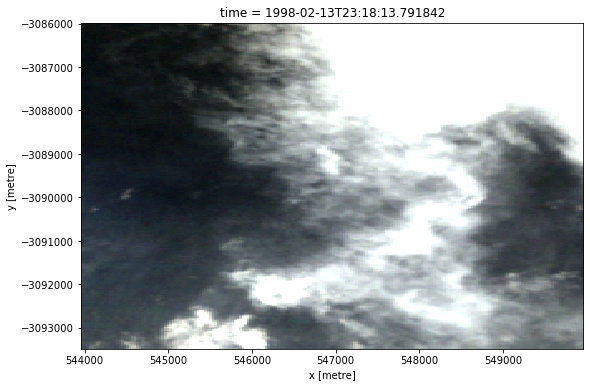

In [25]:
DEAPlotting.rgb(test_ds.isel(time=0, y=slice(1950, 2200), x=slice(130, 330)), 
                bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
                percentile_stretch=(0.0, 0.8))
 
 
 
#  [['nbart_red', 'nbart_green', 'nbart_blue']]

## Extract waterline contours

Operating in single z-value, multiple arrays mode


,obs_n,tide_m_ave,tide_m_std,tide_m_min,tide_m_max,geometry
timeperiod,,,,,,
1987-01-01,3,0.45,0.02,0.45,0.49,"(LINESTRING (554792.8313016123 -3027840, 55479..."
1988-01-01,9,0.57,0.25,0.21,1.14,"(LINESTRING (544657.4567526556 -3029190, 54465..."
1989-01-01,9,0.69,0.17,0.43,0.97,"(LINESTRING (558121.5268445213 -3028560, 55812..."
1990-01-01,8,0.64,0.23,0.20,0.93,"(LINESTRING (552150.6019357815 -3027510, 55215..."
1991-01-01,8,0.57,0.19,0.22,0.83,"(LINESTRING (558721.8170261936 -3028140, 55872..."
1992-01-01,10,0.43,0.25,0.16,0.99,"(LINESTRING (540090 -3067815.250520497, 540096..."
1993-01-01,10,0.30,0.32,0.12,1.10,"(LINESTRING (540090 -3067825.765443842, 540092..."
1994-01-01,12,0.26,0.34,0.10,1.19,"(LINESTRING (540090 -3067821.344529504, 540094..."
1995-01-01,10,0.33,0.23,0.10,0.83,"(LINESTRING (540090 -3067814.747750383, 540096..."


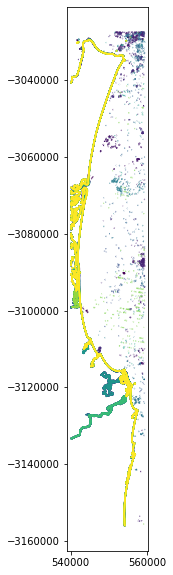

In [47]:
# index_threshold = -0.2
# min_vertices = 20

# Prepare attributes as input to contour extract
attribute_data = {'timeperiod': composite_ds.timeperiod.values.tolist(),
                  'obs_n': composite_ds.obs_n.values.tolist(),                  
                  'tide_m_ave': composite_ds.tide_heights.values.tolist(),
                  'tide_m_std': composite_ds.tide_m_std.values.tolist(),
                  'tide_m_min': composite_ds.tide_m_min.values.tolist(),
                  'tide_m_max': composite_ds.tide_m_max.values.tolist()}  
attribute_dtypes = {'timeperiod': 'str', 'obs_n': 'int', 'tide_m_ave': 'float:15.2', 
                    'tide_m_std': 'float:15.2', 'tide_m_min': 'float:15.2', 'tide_m_max': 'float:15.2'}

# Extract contours with custom attribute fields:
contours_gdf = SpatialTools.contour_extract(z_values=[index_threshold],
                                   ds_array=composite_ds['water_index_clip'],
                                   ds_crs=composite_ds.crs,
                                   ds_affine=composite_ds.geobox.transform,
                                   output_shp=f'output_data/{study_area}/{study_area}_{water_index}_{index_threshold}.shp',
                                   min_vertices=min_vertices,  
                                   attribute_data=attribute_data,
                                   attribute_dtypes=attribute_dtypes,
                                   verbose=False,                                   
                                   dim='timeperiod')

# Plot contours
import matplotlib.pyplot as plt
contours_gdf = contours_gdf.set_index('timeperiod')
fig, ax = plt.subplots(figsize=(10, 10))
contours_gdf.plot(ax=ax, cmap='viridis')
contours_gdf

## Compute change statistics

In [49]:
import fiona
from shapely.geometry import mapping
from shapely.ops import nearest_points
from shapely.geometry import Point, LineString, MultiPoint
import geopandas as gpd

# Read in contours
# contours_gdf = gpd.read_file(f'output_data/{study_area}/{study_area}_{water_index}_{index_threshold}.shp')

# Set annual shoreline to use as a baseline
baseline_year = contours_gdf.index[0]
baseline_contour = contours_gdf.loc[baseline_year].geometry

# Set up output shapefile
schema = {'geometry': 'Point','properties': {'id': 'int'}}
baseline_points_shp = f'output_data/{study_area}/{study_area}_{water_index}_{index_threshold}_statistics.shp' 

with fiona.open(baseline_points_shp, 'w', 'ESRI Shapefile', schema, crs=contours_gdf.crs) as output:
    
    # create points every 30 meters along the line
    for i, distance in enumerate(range(0, int(baseline_contour.length), 30)):
         point = baseline_contour.interpolate(distance)   
         output.write({'geometry': mapping(point), 'properties': {'id': i}}) 


In [50]:
# Read points in as geopandas
points_gdf = gpd.read_file(baseline_points_shp)

# Copy geometry to baseline point
points_gdf['p_baseline'] = points_gdf.geometry
baseline_x_vals = points_gdf.geometry.x
baseline_y_vals = points_gdf.geometry.y

# Get array of water index values for baseline time period 
baseline_array = composite_ds.sel(timeperiod = baseline_year)['water_index']

# Iterate through all comparison years in contour gdf
for comp_year in contours_gdf.index.unique().values:

    print(comp_year)

    # Set comparison contour
    comp_contour = contours_gdf.loc[comp_year].geometry

    # Find nearest point on comparison contour
    points_gdf[f'p_{comp_year}'] = points_gdf.apply(lambda x: 
                                                    nearest_points(x.p_baseline, comp_contour)[1], axis=1)

    # Compute distance between baseline and comparison year points
    points_gdf[f'{comp_year}'] = points_gdf.apply(lambda x: 
                                                  x.geometry.distance(x[f'p_{comp_year}']), axis=1)

    # Extract comparison array
    comp_array = composite_ds.sel(timeperiod = comp_year)['water_index']

    # Convert baseline and comparison year points to geoseries to allow easy access to x and y coords
    comp_x_vals = gpd.GeoSeries(points_gdf[f'p_{comp_year}']).x
    comp_y_vals = gpd.GeoSeries(points_gdf[f'p_{comp_year}']).y

    # Sample NDWI values from arrays based on baseline and comparison points
    baseline_x_vals = xr.DataArray(baseline_x_vals, dims='z')
    baseline_y_vals = xr.DataArray(baseline_y_vals, dims='z')
    comp_x_vals = xr.DataArray(comp_x_vals, dims='z')
    comp_y_vals = xr.DataArray(comp_y_vals, dims='z')   
    points_gdf['index_comp_p1'] = comp_array.interp(x=baseline_x_vals, y=baseline_y_vals)
    points_gdf['index_baseline_p2'] = baseline_array.interp(x=comp_x_vals, y=comp_y_vals)

    # Compute directionality of change (negative = erosion, positive = accretion)    
    points_gdf['loss_gain'] = (points_gdf.index_baseline_p2 > points_gdf.index_comp_p1).astype(int).replace(to_replace=0, value=-1)
    points_gdf[f'{comp_year}'] = points_gdf[f'{comp_year}'] * points_gdf.loss_gain

# Keep required columns
points_gdf = points_gdf[['geometry'] + contours_gdf.index.unique().values.tolist()]
points_gdf = points_gdf.round(2)

# Identify dates for regression
x_years = np.array([int(i[:4]) for i in points_gdf.columns[1:]])

# Identify SOI values for regression
soi_df = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/raw_data/SOI_EastAnglia.txt', 
                     sep='\t', skiprows=1, usecols=['year', 'annual average'], index_col='year')
soi_df = soi_df.rename({'annual average': 'annual_SOI'}, axis=1)
x_soi = soi_df.loc[x_years].annual_SOI.values

# Identify La Nina / El Nino years
lan_eln = np.array(['ElN', 'LaN', 'LaN', 'na', 'ElN', 'ElN', 'ElN', 'ElN', 'na', 'na', 'ElN', 
                    'LaN', 'LaN', 'LaN', 'na', 'ElN', 'na', 'na', 'na', 'ElN', 'LaN', 'LaN', 
                    'ElN', 'LaN', 'LaN', 'na', 'na', 'na', 'ElN', 'na', 'na', 'na'])
lan_eln_df = pd.DataFrame({'year': range(1987, 2019), 'lan_eln': lan_eln}).set_index('year')
x_lan_eln = lan_eln_df.loc[x_years].lan_eln.values

# Get custom x values
x_neg = np.where(x_soi >= 0, x_soi, np.nan)
x_pos = np.where(x_soi <= 0, x_soi, np.nan)
x_lan = np.where(x_lan_eln == 'LaN', x_soi, np.nan)
x_eln = np.where(x_lan_eln == 'ElN', x_soi, np.nan)

# Compute change rates
rate_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_years, x_labels = x_years, std_dev=3), axis=1)
soi_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_soi, x_labels = x_years, std_dev=3), axis=1)
neg_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_neg, x_labels = x_years, std_dev=3), axis=1)
pos_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_pos, x_labels = x_years, std_dev=3), axis=1)
eln_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_eln, x_labels = x_years, std_dev=3), axis=1)
lan_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_lan, x_labels = x_years, std_dev=3), axis=1)
points_gdf[['mov_rate', 'mov_sig', 'mov_outl']] = rate_out
points_gdf[['soi_rate', 'soi_sig', 'soi_outl']] = soi_out
points_gdf[['neg_rate', 'neg_sig', 'neg_outl']] = neg_out
points_gdf[['pos_rate', 'pos_sig', 'pos_outl']] = pos_out
points_gdf[['eln_rate', 'eln_sig', 'eln_outl']] = eln_out
points_gdf[['lan_rate', 'lan_sig', 'lan_outl']] = lan_out

# Set insignificant rates to nan
points_gdf.loc[points_gdf.mov_sig > 0.05, 'mov_rate'] = np.nan
points_gdf.loc[points_gdf.soi_sig > 0.05, 'soi_rate'] = np.nan
points_gdf.loc[points_gdf.neg_sig > 0.05, 'neg_rate'] = np.nan
points_gdf.loc[points_gdf.pos_sig > 0.05, 'pos_rate'] = np.nan
points_gdf.loc[points_gdf.eln_sig > 0.05, 'eln_rate'] = np.nan
points_gdf.loc[points_gdf.lan_sig > 0.05, 'lan_rate'] = np.nan

# Export to file
points_gdf.crs = str(composite_ds.crs)
points_gdf.to_file(baseline_points_shp)    


1987-01-01
1988-01-01
1989-01-01
1990-01-01
1991-01-01
1992-01-01
1993-01-01
1994-01-01
1995-01-01
1996-01-01
1997-01-01
1998-01-01
1999-01-01
2000-01-01
2001-01-01
2002-01-01
2003-01-01
2004-01-01
2005-01-01
2006-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01


In [ ]:
# # Read points in as geopandas
# points_gdf = gpd.read_file(output_file)

# # Copy geometry to baseline point
# points_gdf['p_baseline'] = points_gdf.geometry
# baseline_x_vals = points_gdf.geometry.x
# baseline_y_vals = points_gdf.geometry.y

# # Get array of water index values for baseline time period 
# baseline_array = composite_ds.sel(timeperiod = baseline_year)[water_index]
# baseline_array

# # Set comparison contour
# comp_year = '2014-01-01'
# comp_contour = contours_gdf.loc[comp_year].geometry

# # Add P2 point
# points_gdf[f'p_{comp_year}'] = points_gdf.apply(lambda x: 
#                                                 nearest_points(x.p_baseline, comp_contour)[1], axis=1)

# points_gdf.head()

In [ ]:
# x_soi > 0

## Compute SOI stats file

In [ ]:
# # Read points in as geopandas
# points_gdf = gpd.read_file('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/output_data/cabarita/cabarita_mndwi_0.1_statistics.shp')

# # Add point ID column
# points_gdf['point_id'] = [f'point_{i}' for i in range(points_gdf.shape[0])]

In [ ]:
# # Read in SOI values
# soi_df = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/raw_data/SOI_EastAnglia.txt', sep='\t', skiprows=1)

# # Change format of dates
# soi_df['year'] = [f'{i}-01-01' for i in soi_df.year]

# # # Rename SOI field
# # soi_df = soi_df.rename({'annual average': 'annual_SOI'}, axis=1)
# # soi_df['annual_SOI'] = soi_df.iloc[:, 2:-1].apply(lambda x: max(x.min(), x.max(), key=abs), axis=1)  
# soi_df['annual_SOI'] = soi_df.iloc[:, 2:-1].apply(np.nanmedian, axis=1)  
# soi_df = soi_df.loc[:, ['year', 'annual_SOI']]
# soi_df.head()

In [ ]:
# points_melt_df = points_gdf.melt(id_vars=['point_id', 'rate_chang', 'rate_sig'], 
#                                  value_vars=points_gdf.columns[0:-5], var_name='year', value_name='annual_move')

In [ ]:
# points_melt_df = points_melt_df.merge(soi_df, on='year')
# points_melt_df.head()


In [ ]:
# points_melt_df.crs = 'EPSG:32656'
# mostcommon_utm(dc=dc_upgrade, product='ls5_ard', query=query)

# points_melt_df.to_file('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/output_data/cabarita/cabarita_mndwi_0.1_soi.shp')

In [ ]:
# # test = points_melt_df[(points_melt_df.year != '2012-01-01') & 
# #                (points_melt_df.rate_sig > 0.05) & 
# #                (points_melt_df.annual_move.abs() < 100)]

# test = points_melt_df

# test.plot.scatter(x='annual_SOI', y='annual_move', alpha=1.0)
# import statsmodels.api as sm
# import matplotlib.pyplot as plt
# model = sm.formula.ols(formula='annual_move ~ annual_SOI', data=test)
# res = model.fit()
# test.assign(fit=res.fittedvalues).plot(x='annual_SOI', y='fit', ax=plt.gca(), color='red')

In [ ]:
# test = test[(points_melt_df.rate_sig > 0.05)].groupby('year').median()   #.plot.scatter(x='annual_SOI', y='annual_move', alpha=1.0)
# test.plot.scatter(x='annual_SOI', y='annual_move', alpha=1.0)
# import statsmodels.api as sm
# import matplotlib.pyplot as plt
# model = sm.formula.ols(formula='annual_move ~ annual_SOI', data=test)
# res = model.fit()
# test.assign(fit=res.fittedvalues).plot(x='annual_SOI', y='fit', ax=plt.gca(), color='red')

In [ ]:
# test

In [ ]:
# query = {'y': lat_extents,
#          'x': lon_extents,
#          'crs': 'EPSG:4326',
#          'time': ('1986-01-01', '2020-01-01')}